In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio
plt.close('all')
import random
import os
import math
from scipy.optimize import curve_fit

In [12]:
def prob(x0,y0,x,y,a,A):
    r=np.sqrt((x-x0)**2+(y-y0)**2)
    if r==0:
        return 1
    else:
        p=A*np.exp(-(r**a))#A/(r**(a))
        #print(p)
        return p
   
    
def makec(p):
    p=int(p*100)
    t=np.random.random_integers(100)
    #print(t,p)
    if p>t:
        return True
    else:
        return False
    
    
def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = (r * a + (1.0 - a) * R) /255
    rgb[:,:,1] = (g * a + (1.0 - a) * G) /255
    rgb[:,:,2] = (b * a + (1.0 - a) * B) /255

    return np.asarray( rgb, dtype='uint8' )


def circle(x0,y0,r):
    
    x1=np.linspace(x0-r,x0+r,3000,endpoint=True)
    x2=np.linspace(x0-r,x0+r,3000,endpoint=True)
    y1=np.sqrt(r**2-(x1-x0)**2)+y0
    y2=-1*np.sqrt(r**2-(x1-x0)**2)+y0
    x=np.append(x1,x2)
    y=np.append(y1,y2)
        
    return x,y 

def circletest(x0, y0, r0, x1, y1, r1):
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1

    d=np.sqrt((x1-x0)**2 + (y1-y0)**2)
    
    #print('d',d,r1,r0)
    
    # non intersecting
    if d > r0 + r1 and r0 != r1:
        #print('1')
        return 0
    # One circle within other
    if d < abs(r0-r1):
        #print('2')
        return 1
    # coincident circles
    if d == 0 and r0 == r1:
        #print('3')
        return 0
    else:
        #print('4')
        return 1

    
def splitprob(r,low,high):
    if r <= low:
        diff = 0
    else:
        diff = ((1/(high-low))**3 * (r-low)**3)*100
    return 100-diff

def distance(circle_a, circle_b):
    return ((circle_a.x - circle_b.x) ** 2 + (circle_a.y - circle_b.y) ** 2) ** 0.5
    
def circletest_array(x0, y0, r0):
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1
    c_m=np.zeros((len(x0),len(x0)))
    
    
    for i in range(len(x0)):
         for j in range(len(x0)):
                c_m[i,j]=circletest(x0[i], y0[i], r0[i], x0[j], y0[j], r0[j])
    
    #print('sum',np.sum(c_m))
    return np.sum(c_m)
    
def ini_pic(b, r_mu, r_sig, pix_max,pix_min, t, run, bg=False):
    my_dpi = 96
    
    if not os.path.isdir('./' + str(run)):
        os.mkdir('./' + str(run))
        os.mkdir('./' + str(run) + '_GT')
    
    fig = plt.figure(figsize=(pix_max / my_dpi, pix_max / my_dpi), dpi=my_dpi)
    ax = fig.gca()
    
    circles = []
    
    x=np.array([])
    y=np.array([])
    x0c=np.array([2])
    y0c=np.array([0.5])
    rc=np.array([0])
    split_prob=np.array([0])
    
    x_pos = np.linspace(0.01 * r_mu, 1 - 0.01 * r_mu, 1500)
    y_pos = np.linspace(0.01 * r_mu, (pix_min/pix_max) - 0.01 * r_mu, int((pix_min/pix_max)*1500))
    
    for _ in range(b):
        x0 = np.random.choice(x_pos)
        y0 = np.random.choice(y_pos)
        r_com = np.random.normal(r_mu, r_sig, 1)
        
        circle = Circle(x0, y0, r_com)
        circles.append(circle)
    
    resolve_all_overlaps(circles)
    
    # Extract updated x, y, r values for plotting
    xu, yu, ru = zip(*[(circle.x, circle.y, circle.radius) for circle in circles])
    
    x0c = np.append(x0c,xu)
    y0c = np.append(y0c,yu)
    rc = np.append(rc,ru)
    
    split_prob = [100 - splitprob(radius, 0.035, 0.06) for radius in rc]
    
    for circle in circles:
        circ = plt.Circle((circle.x, circle.y), circle.radius, color='red', fill=False)
        ax.add_patch(circ)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(0, 1)
    plt.ylim(0, (pix_min/pix_max))
    plt.savefig('./' + str(run) + '/' + str(t) + '.png', dpi=my_dpi, transparent=False)
    plt.close()
    
    r_count = np.unique(rc)
    ide = np.append(-1, np.arange(1, b + 1))
    '''
    if len(r_count) < b:
        print('!!!!!!!!!!!!!!!!!', len(r_count))
        x0c, y0c, rc, ide, split_prob = ini_pic(b, r_i, pix, t, run, bg=False)
    '''
    return x0c, y0c, rc, ide, split_prob

def gt(x,y,r,t,run,ide,split_prob,split_id=0,savefile=True,shuffle=False):
    
    
    #plt.rcParams['axes.facecolor'] = 'black'
    my_dpi=96
    
    #print('r',r,np.mean(r))


    t_v=np.ones(len(x))*t
    
    if t==0:
        split_id=np.zeros(len(x))
    
    if shuffle:
        ind = np.argsort(x) 
        #print('ind',ind)
        random.shuffle(ind)
        #print('ind',ind)
        x=np.array(x)
        y=np.array(y)
        r=np.array(r)
        #print('x',x)
        #print('y',y)
        x= np.take_along_axis(x, ind, axis=-1)  
        #print('x2',x)
        
        y=np.take_along_axis(y, ind, axis=-1) 
        
        #print('y2',y)
        #print('ind2',ind)
        r=np.take_along_axis(r, ind, axis=-1)
        ide=np.take_along_axis(ide, ind, axis=-1)
        split_id=np.take_along_axis(split_id, ind, axis=-1)
        split_prob=np.take_along_axis(split_prob, ind, axis=-1)
    
    
    
    if savefile:
        if t==0:
            np.savetxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt', np.c_[x,y,r,ide,split_id,split_prob,t_v],delimiter='\t',header='x'+'\t'+'y'+'\t'+'r'+'\t'+'id'+'\t'+'split_id'+'\t'+'s_prob'+'\t'+'t')
        else:    
            xl,yl,rl,idel,split_l,s_pr_l,t_vl= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)
            
            xl=np.append(xl,x)
            yl=np.append(yl,y)
            rl=np.append(rl,r)
            t_vl=np.append(t_vl,t_v)
            idel=np.append(idel,ide)
            split_l=np.append(split_l,split_id)
            s_pr_l=np.append(s_pr_l,split_prob)
            np.savetxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt', np.c_[xl,yl,rl,idel,split_l,s_pr_l,t_vl],delimiter='\t',header='x'+'\t'+'y'+'\t'+'r'+'\t'+'id'+'\t'+'split_id'+'\t'+'s_prob'+'\t'+'t')
    plt.close()

def move(x,y,r,mv_mu,mv_std,sp_prob,t,r_split,pix_max,pix_min,run,ide,reco=True,forget=True,directed=0):
    
    
    vec=np.linspace(0,2*np.pi,500)

    n=pix_max
    my_dpi=96
    fig = plt.figure(figsize=(pix_max/my_dpi, pix_max/my_dpi), dpi=my_dpi)
    
    plt.axis('off')
    
    plt.gca().set_aspect('equal', adjustable='box')
    ax = fig.gca()
    plt.xlim(0,1)
    plt.ylim(0,pix_min/pix_max)
    
    

    
    #xp=np.array([0,1])
    #yp=np.array([0,1])
    
    pl=True
    
    

        

    re = np.array([])
    x0c=np.array([])
    y0c=np.array([])
    r0c=np.array([])
    idec=np.array([])
    split_id=np.array([])
    split_prob=np.array([])
    flag=0

       
    for i in range(len(x)):
        phi=np.random.choice(vec)
        mv = rejection_sample(mv_mu, mv_sig)
        x_n=x[i]+(mv/pix_max)*np.sin(phi)
        y_n=y[i]+(mv/pix_max)*np.cos(phi)
        
        
        r_e0=0 #!!!!!!!!
        if r[i] < 0.35*r_mu:
            r_e0 = np.random.random_integers(8,12)
            
        re=np.append(re,r_e0)
        #print('ri0',r[i])
        r[i] = r[i]*(1+(r_e0/100))
        #print('ri1',r[i])

        if x_n < 0 or x_n > 1:
            x_n=x[i]-(mv/pix_max)*np.sin(phi)

        if y_n < 0 or y_n > pix_min/pix_max:
            y_n=y[i]-(mv/pix_max)*np.cos(phi)


        sp=np.random.random_integers(99)
        #print('ri',r[i])
        if percent_true(sp_prob) and t>7 and r[i]>r_split:###splitprob(r[i],0.035,0.06): ###96
            #print(r[i],'split',splitprob(r[i],0.035,0.06))
            flag=flag+1
            d=1.5
            x_n1, y_n1, x_n2, y_n2 = split_cell_axis(x_n, y_n, r[i], d)
            
            
            #x_n1=x_n-1.05*r[i]
            #x_n2=x_n+1.05*r[i]


            #r_e=np.random.random_integers(5)

            #r_n1= r[i]*(1+(r_e/100))
            #r_n2= r[i]*(1-(r_e/100))

            #print('r_n1')
            #r_e1=np.random.random_integers(15,40)
            #r_e2=np.random.random_integers(15,40)
            
            r_e1=np.random.random_integers(45,65)
            

            z=0
            while z<100:


                r_n1= r[i]*(1-(r_e1/100))
                r_n2= r[i]*(1-(r_e1/100))
                #print('r_n1',r_n1)
                #print('r_n2',r_n2)
                if r_n1 in r or r_n2 in r:
                    #print('while',r)
                    r_e1=np.random.random_integers(40,65)
                    #print('r_e',r_e)
                    #r_n1= r[i]*(1+(r_z/100))+r_n1/100
                    #r_n2= r[i]*(1-(r_z/100))+r_n2/100


                    #print()
                    z=z+1
                else:

                    break


            circ1=plt.Circle((x_n1,y_n1), r_n1, color='red',fill=False)
            circ2=plt.Circle((x_n2,y_n2), r_n2, color='red',fill=False)
            ax.add_patch(circ1)
            ax.add_patch(circ2)
            x0c=np.append(x0c,x_n1)
            y0c=np.append(y0c,y_n1)
            x0c=np.append(x0c,x_n2)
            y0c=np.append(y0c,y_n2)

            split_id=np.append(split_id,ide[i])
            split_id=np.append(split_id,ide[i])
            
            split_prob=np.append(split_prob,100-splitprob(r_n1,0.035,0.06))
            split_prob=np.append(split_prob,100-splitprob(r_n2,0.035,0.06))


            if len(idec)!=0:
                max_id=np.max(np.append(ide,idec))
            else:
                max_id=np.max(ide)


            idec=np.append(idec,max_id+1)
            idec=np.append(idec,max_id+2)

            r0c=np.append(r0c,r_n1)
            r0c=np.append(r0c,r_n2)
        else:
            #print(r[i],'nosplit',splitprob(r[i],0.035,0.06))
            split_id=np.append(split_id,0)
            circ=plt.Circle((x_n,y_n), r[i], color='red',fill=False)
            ax.add_patch(circ)
            x0c=np.append(x0c,x_n)
            y0c=np.append(y0c,y_n)
            r0c=np.append(r0c,r[i])
            split_prob=np.append(split_prob,100-splitprob(r[i],0.035,0.06))

            idec=np.append(idec,ide[i])

    circles = [Circle(x, y, r) for x, y, r in zip(x0c, y0c, r0c)]

    # Resolve overlaps
    resolve_all_overlaps(circles)

    # Update your circle lists with new values after resolving overlaps
    x0c = [circle.x for circle in circles]
    y0c = [circle.y for circle in circles]
    r0c = [circle.radius for circle in circles]

                
    
    
    
    
    n_miss=0
        
    #plt.scatter(xp,yp,s=pix**2/n**2,c='blue')
    
    if pl != False:
        plt.savefig('./'+str(run)+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 
        plt.close()
        
    return x0c, y0c, r0c,idec,split_id,split_prob
        

#plt.ioff()      




    





def split_cell_axis(x_n, y_n, r, d):
    """
    Calculates new positions for the daughter cells of a splitting cell.

    Parameters:
    x_n (float): x position of the parent cell
    y_n (float): y position of the parent cell
    r (float): radius of the parent cell
    theta (float): orientation angle of the split in radians

    Returns:
    tuple: new x and y positions for both daughter cells
    """
    theta = random.uniform(0, 2 * np.pi)
    
    # Displacement along the axis
    delta_x = d * r * np.cos(theta)
    delta_y = d * r * np.sin(theta)

    x_n1 = x_n - delta_x
    y_n1 = y_n - delta_y

    x_n2 = x_n + delta_x
    y_n2 = y_n + delta_y

    return x_n1, y_n1, x_n2, y_n2



def adjust_radius(filepath):
    # Read the data from the file
    with open(filepath, 'r') as file:
        lines = file.readlines()

    # Remove header and store it
    header = lines.pop(0)

    # Process data lines
    data = [list(map(float, line.split())) for line in lines]

    # Find parent cells of all splits
    split_parents = {}
    for line in data:
        split_id = int(line[4])
        if split_id != 0:
            split_parents[split_id] = int(line[6])  # key = split_id, value = split time

    # Adjust radius for each parent cell
    for parent_id, split_time in split_parents.items():
        for line in data:
            cell_id = int(line[3])
            time = int(line[6])

            if cell_id == parent_id:
                if time == split_time - 6:
                    initial_radius = line[2]
                    half= random.uniform(1.6, 2.1)
                    quart = random.uniform(3.6, 4.2)
                if split_time - 6 <= time < split_time:
                    # Adjust the radius
                    
                    if split_time - 6 <= time <= split_time - 5:
                        line[2] = initial_radius / half
                    else:
                        line[2] = initial_radius / quart

    # Convert back to string format and write to file
    with open(filepath, 'w') as file:
        file.write(header)
        for line in data:
            str_line = "\t".join(map(str, line)) + '\n'
            file.write(str_line)

# Test the function


def plot_radius_over_time(filepath, cell_id):
    # Read the data from the file
    with open(filepath, 'r') as file:
        lines = file.readlines()

    # Remove header
    lines.pop(0)

    # Process data lines
    data = [list(map(float, line.split())) for line in lines]

    # Extract time and radius for the specified cell ID
    times = []
    radii = []
    for line in data:
        if int(line[3]) == cell_id:
            times.append(int(line[6]))
            radii.append(line[2])

    # Plot
    plt.plot(times, radii, marker='o', linestyle='-', color='b')
    plt.xlabel('Time')
    plt.ylabel('Radius')
    plt.title(f'Radius Over Time for Cell ID {cell_id}')
    plt.grid(True)
    plt.show()

    
    
    
def resolve_all_overlaps(circles, max_iterations=1000, WIDTH=100, HEIGHT=100):
    for k in range(max_iterations):
        any_overlap = False
        for i, circle_a in enumerate(circles):
            for j, circle_b in enumerate(circles):
                if i != j and circle_a.intersects(circle_b):
                    any_overlap = True
                    overlap_distance = circle_a.radius + circle_b.radius - distance(circle_a, circle_b)
                    move_distance = overlap_distance / 2 + 0.01

                    # Calculate angle of repulsion
                    angle = math.atan2(circle_a.y - circle_b.y, circle_a.x - circle_b.x)

                    # Add noise to the angle
                    noise = random.uniform(-0.2, 0.2)  # Adjust this value for more or less noise
                    angle += noise

                    # Calculate the forces for the two circles
                    force_a = move_distance + random.uniform(0, 0.2 * move_distance)
                    force_b = move_distance + random.uniform(0, 0.2 * move_distance)

                    # Update circle positions based on the repulsion force
                    circle_a.x += math.cos(angle) * force_a
                    circle_a.y += math.sin(angle) * force_a

                    circle_b.x -= math.cos(angle) * force_b
                    circle_b.y -= math.sin(angle) * force_b

                    # Ensure circle centers stay inside boundaries
                    circle_a.x = max(circle_a.radius, min(WIDTH - circle_a.radius, circle_a.x))
                    circle_a.y = max(circle_a.radius, min(HEIGHT - circle_a.radius, circle_a.y))

                    circle_b.x = max(circle_b.radius, min(WIDTH - circle_b.radius, circle_b.x))
                    circle_b.y = max(circle_b.radius, min(HEIGHT - circle_b.radius, circle_b.y))

        if not any_overlap:
            #print('K',k)
            break

# Test the function
class Circle:
    def __init__(self, x, y, radius):
        self.x = x
        self.y = y
        self.radius = radius

    def __repr__(self):
        return f"Circle({self.x}, {self.y}, {self.radius})"
    
    def intersects(self, other):
        """Check if this circle intersects with another circle."""
        distance = ((self.x - other.x) ** 2 + (self.y - other.y) ** 2) ** 0.5
        return distance < (self.radius + other.radius)

    def bounding_box(self):
        """Return the bounding box of the circle."""
        return Rectangle(self.x - self.radius, self.y - self.radius, self.x + self.radius, self.y + self.radius)
    
    
def rejection_sample(mv_mu, mv_sig):
    while True:
        mv = np.random.normal(mv_mu, mv_sig, 1)
        if mv >= 0:
            return mv
        
def compute_radius_stats(mu_area, sigma_area):
    mu_radius = np.sqrt(mu_area / np.pi)
    sigma_radius = sigma_area / (2 * np.sqrt(np.pi * mu_area))
    return mu_radius, sigma_radius

def percent_true(p):
    return random.random() < p


def func_neg(x, a, b, c):
    return (1 - a * (b ** x)) + c

def adjust_radius_using_func(time_since_split, initial_radius, popt_neg):
    size_ratio = func_neg(time_since_split, *popt_neg)
    return initial_radius * size_ratio

def modify_file_radius(filepath, popt_neg):
    # Read the data from the file
    with open(filepath, 'r') as file:
        lines = file.readlines()

    # Remove header and store it
    header = lines.pop(0)

    # Process data lines
    data = [list(map(float, line.split())) for line in lines]

    # Find parent cells of all splits
    split_parents = {}
    for line in data:
        split_id = int(line[4])
        if split_id != 0:
            split_parents[split_id] = int(line[6])  # key = split_id, value = split time

    # Adjust radius for each parent cell
    for parent_id, split_time in split_parents.items():
        for line in data:
            cell_id = int(line[3])
            time = int(line[6])

            if cell_id == parent_id:
                time_since_split = time - split_time
                if time_since_split == -6:
                    initial_radius = line[2]
                if -6 <= time_since_split < 0:
                    # Adjust the radius using the func_neg
                    line[2] = adjust_radius_using_func(time_since_split, initial_radius, popt_neg)

    # Convert back to string format and write to file
    with open(filepath, 'w') as file:
        file.write(header)
        for line in data:
            str_line = "\t".join(map(str, line)) + '\n'
            file.write(str_line)

            
def two_gaussians(x, A1, mu1, sigma1, A2, mu2, sigma2):
    g1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    g2 = A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))
    return g1 + g2

In [3]:
a=np.array([4,4,5,3,1])
b=np.array([1,2,3,4,5])
print(a[1:])

[4 5 3 1]


In [17]:
#print(stop)
#forget=True
pix_max=512
pix_min=512


non_dep_area=np.array([[303.895110,65.808600],[736.305768,223.811745]])



mv_mu=0.523662
mv_sig=0.508994
sp_mu=0.834381/100 #3.
sp_sig=0.552273/100

combined_radii=[]
for i in range(1,100):
    ind_a=random.choice([0, 1])
    print(ind_a)
    
    sm_max_area=[250,850]
    max_area=sm_max_area[ind_a]
    r_split=np.sqrt(max_area/np.pi)/pix_max
    A_mu=non_dep_area[ind_a][0]
    A_sig=non_dep_area[ind_a][1]
    sp_prob=np.random.normal(sp_mu, sp_sig, 1)
    sp_prob=0.005 #!!!!!!!!!!!
    print('iiiiiiiiiiiiii',i,sp_prob)
    t=10
    b=10
    r_mu,r_sig= compute_radius_stats(A_mu, A_sig)
    print(r_mu)
    r_mu=r_mu/pix_max
    r_sig=r_sig/pix_max

    run=i
    x_f, y_f, r_f,idec_f,split_prob_f=ini_pic(b,r_mu,r_sig,pix_max,pix_min,0,run)
   
    #print(len(x), len(y), len(r), len(ide), len(split_prob))
    gt(x_f,y_f,r_f,0,run,idec_f,split_prob_f)
    #mv=0.02
    
           
    x_f=x_f[idec_f>0]
    y_f=y_f[idec_f>0]
    r_f=r_f[idec_f>0]
    idec_f=idec_f[idec_f>0]
    


    for l in range(1,t):
        

        
        x_f, y_f, r_f,idec_f,split_id_f,split_prob_f = move(x_f,y_f,r_f,mv_mu,mv_sig,sp_prob,l,r_split,pix_max,pix_min,run,idec_f,forget=False,directed=0)

            
        #print(l,len(x),ide)
        #x,y,r = ini_pic(b,r_i,pix,l,run)
        gt(x_f,y_f,r_f,l,run,idec_f,split_prob_f,split_id_f,shuffle=True)
    filepath='./'+str(i)+'_GT'+'/'+'pos_GT.txt'
    popt_neg=[0.55618812, 1.54775129, 0.01123954]
    modify_file_radius(filepath, popt_neg)
    data = np.loadtxt(filepath, delimiter='\t', skiprows=1, usecols=(2))
    combined_radii.extend(data)


0
iiiiiiiiiiiiii 1 0.005
9.83528433121842


/tmp/ipykernel_231651/1233729747.py:278: DeprecationWarning: This function is deprecated. Please call randint(1, 99 + 1) instead
  sp=np.random.random_integers(99)


0
iiiiiiiiiiiiii 2 0.005
9.83528433121842
1
iiiiiiiiiiiiii 3 0.005
15.309258806635563
0
iiiiiiiiiiiiii 4 0.005
9.83528433121842
1
iiiiiiiiiiiiii 5 0.005
15.309258806635563
1
iiiiiiiiiiiiii 6 0.005
15.309258806635563
1
iiiiiiiiiiiiii 7 0.005
15.309258806635563
1
iiiiiiiiiiiiii 8 0.005
15.309258806635563
1
iiiiiiiiiiiiii 9 0.005
15.309258806635563
1
iiiiiiiiiiiiii 10 0.005
15.309258806635563
1
iiiiiiiiiiiiii 11 0.005
15.309258806635563
0
iiiiiiiiiiiiii 12 0.005
9.83528433121842
0
iiiiiiiiiiiiii 13 0.005
9.83528433121842
1
iiiiiiiiiiiiii 14 0.005
15.309258806635563
1
iiiiiiiiiiiiii 15 0.005
15.309258806635563
1
iiiiiiiiiiiiii 16 0.005
15.309258806635563


/tmp/ipykernel_231651/1233729747.py:300: DeprecationWarning: This function is deprecated. Please call randint(45, 65 + 1) instead
  r_e1=np.random.random_integers(45,65)


1
iiiiiiiiiiiiii 17 0.005
15.309258806635563
0
iiiiiiiiiiiiii 18 0.005
9.83528433121842
1
iiiiiiiiiiiiii 19 0.005
15.309258806635563
1
iiiiiiiiiiiiii 20 0.005
15.309258806635563
0
iiiiiiiiiiiiii 21 0.005
9.83528433121842
0
iiiiiiiiiiiiii 22 0.005
9.83528433121842
1
iiiiiiiiiiiiii 23 0.005
15.309258806635563
1
iiiiiiiiiiiiii 24 0.005
15.309258806635563
1
iiiiiiiiiiiiii 25 0.005
15.309258806635563
0
iiiiiiiiiiiiii 26 0.005
9.83528433121842
1
iiiiiiiiiiiiii 27 0.005
15.309258806635563
1
iiiiiiiiiiiiii 28 0.005
15.309258806635563
1
iiiiiiiiiiiiii 29 0.005
15.309258806635563
1
iiiiiiiiiiiiii 30 0.005
15.309258806635563
1
iiiiiiiiiiiiii 31 0.005
15.309258806635563
1
iiiiiiiiiiiiii 32 0.005
15.309258806635563
1
iiiiiiiiiiiiii 33 0.005
15.309258806635563
0
iiiiiiiiiiiiii 34 0.005
9.83528433121842
0
iiiiiiiiiiiiii 35 0.005
9.83528433121842
1
iiiiiiiiiiiiii 36 0.005
15.309258806635563
1
iiiiiiiiiiiiii 37 0.005
15.309258806635563
1
iiiiiiiiiiiiii 38 0.005
15.309258806635563
0
iiiiiiiiiiiiii 39 0.

Fitted parameters: [3.38174078e+02 1.88906165e-02 1.85045937e-03 2.06891050e+02
 2.96510852e-02 5.10578405e-03]


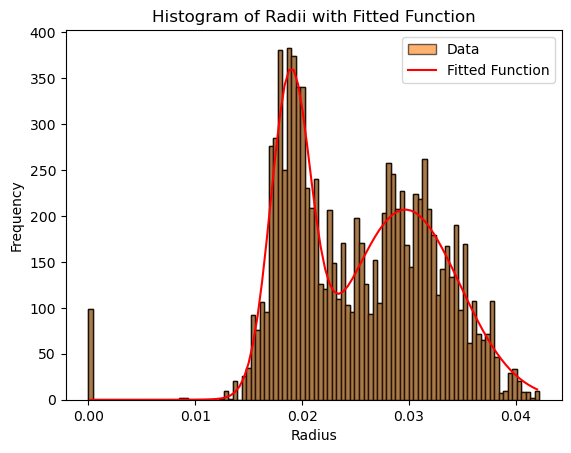

In [18]:
counts, bins, _ = plt.hist(combined_radii, bins=100, edgecolor='k')
bin_centers = (bins[:-1] + bins[1:]) / 2

# 2. Fit the function to the histogram data
popt, pcov = curve_fit(two_gaussians, bin_centers, counts, maxfev=5000,p0=[140,0.02,0.005,80,0.03,0.015])
print("Fitted parameters:", popt)

# 3. Plot the histogram and overlay the fitted function
plt.hist(combined_radii, bins=100, edgecolor='k', label="Data", alpha=0.6)
plt.plot(bin_centers, two_gaussians(bin_centers, *popt), color="red", label="Fitted Function")

plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.title('Histogram of Radii with Fitted Function')
plt.legend()
plt.show()
# radius =  map_value_linear(value, 0.003, 0.45, 2, 8)

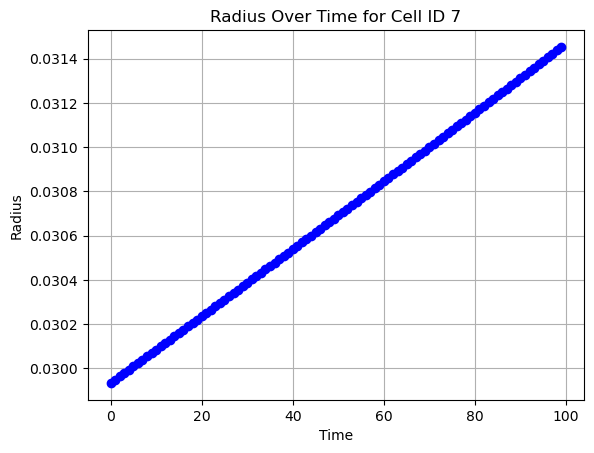

In [6]:
filepath = './'+str(1)+'_GT'+'/'+'pos_GT.txt'
cell_id = 7  # replace with your desired cell ID
plot_radius_over_time(filepath, cell_id)


In [7]:
x=0.034
c=0.03366667
b=[0.03366667,0.034,0.03466667]

print(x in b or c in b)

print(np.arange(1,4))

True
[1 2 3]


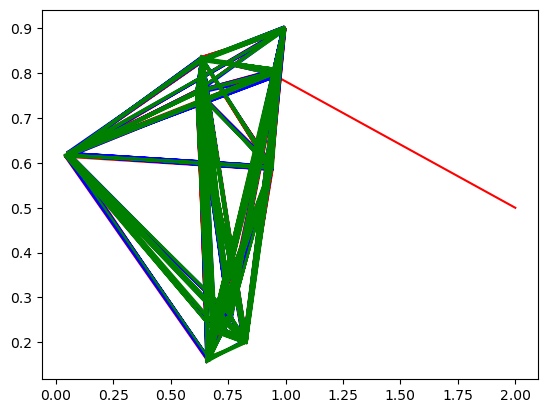

In [8]:
run=3
xl,yl,rl= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2), unpack=True)

x1=[]
y1=[]
x2_t=[]
y2_t=[]
x2=[]
y2=[]
x3=[]
y3=[]

for i in range(len(xl)):
    if i % 3 == 0:
        x1.append(xl[i])
        y1.append(yl[i])
        
    else:
        x2_t.append(xl[i])
        y2_t.append(yl[i])
        
for i in range(len(x2_t)):
    
    if i % 2 == 0:
        x2.append(x2_t[i])
        y2.append(y2_t[i])
        
    else:
        x3.append(x2_t[i])
        y3.append(y2_t[i])
        
        



plt.plot(x1,y1,c='red')
plt.plot(x2,y2,c='blue')
plt.plot(x3,y3,c='green')
plt.show()